In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import os
import seaborn as sns
import anndata

cmap = cm.plasma
plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

# my code
%load_ext autoreload
%autoreload 2
from passenger.plot.plot import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
patient = "P3"
adata = anndata.read_h5ad("/home/vmarotl/fast/mutaseq/scripts/clonal_tracing_notebooks//processed_data/AML_MutaSeq/"+patient+".h5ad")


In [29]:
IDH2_var_pos = 90088702

from scipy.io import mmread
from passenger.preprocess.import_data import *
path = "/home/vmarotl/fast/mutaseq/raw_data/P3/chr15/"
f = open(path+'/cellSNP.tag.AD.mtx', 'r')
ALT = pd.DataFrame(mmread(f).A)

f = open(path + '/cellSNP.tag.DP.mtx', 'r')
DP = pd.DataFrame(mmread(f).A)

REF = DP - ALT
meta = get_meta(path + '/cellSNP.base.vcf', path + '/annotations.tsv', "x", None)
pos = np.where(meta.pos == IDH2_var_pos)[0][0]

mut = ALT.iloc[pos]
ref = REF.iloc[pos]

leuk_COV = mut+ref
leuk_VAF = mut/leuk_COV

leuk_VAF[leuk_COV<=2]=np.nan
cell_names = patient+"_"+np.array(pd.read_csv("~/fast/mutaseq/raw_data/P3/filenames.txt", header=None)[0].str.split("/").str[-1].str.split("_").str[2])
leuk_VAF.index = cell_names
leuk_VAF = leuk_VAF.loc[adata.obs_names]

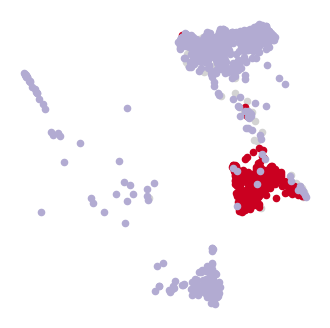

In [30]:
C = adata.obsm["C"]
sub_cells =np.abs(C[:,0]-C[:,1])>.3

f,ax = plt.subplots(1,1, figsize=(4,4))

cancer_cells = sub_cells & (C[:,1]>.5)
healthy_cells = sub_cells & (C[:,1]<.5)

umap = adata.obsm["umap"]
plt.scatter(umap["UMAP_1"][~sub_cells], umap["UMAP_2"][~sub_cells], color="lightgrey", s=20, label="undetermined")
plt.scatter(umap["UMAP_1"][cancer_cells], umap["UMAP_2"][cancer_cells], color="#ca0020", s=20, label="cancer")
plt.scatter(umap["UMAP_1"][healthy_cells], umap["UMAP_2"][healthy_cells], color="#b2abd2", s=20, label="healthy")
#plt.legend()

ax.axis('off')
plt.savefig("../figures/S7_A_P3-our-labels-UMAP.pdf", bbox_inches='tight', format='pdf', dpi=300)
plt.show()
plt.close()

/tmp/7181828.1.all.q/ipykernel_8850/1767969320.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap["UMAP_1"][np.isnan(leuk_VAF)], umap["UMAP_2"][np.isnan(leuk_VAF)], color="lightgrey", s=20, cmap=var_cmap)


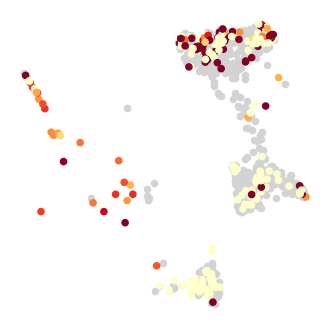

In [31]:
f,ax = plt.subplots(1,1, figsize=(4,4))

plt.scatter(umap["UMAP_1"][np.isnan(leuk_VAF)], umap["UMAP_2"][np.isnan(leuk_VAF)], color="lightgrey", s=20, cmap=var_cmap)
plt.scatter(umap["UMAP_1"], umap["UMAP_2"], c=leuk_VAF, s=20, cmap=var_cmap)
#plt.colorbar()

ax.axis('off')
plt.savefig("../figures/S7_B_P3-IDH2-VAF-UMAP.pdf", bbox_inches='tight', format='pdf', dpi=300)
plt.show()
plt.close()

In [32]:
# ordering of cells for ease of comparison

row_ind = pd.DataFrame(C>.5, index = adata.obs_names)
row_ind = pd.concat((row_ind, leuk_VAF), axis=1).loc[sub_cells]

row_ind.columns = np.arange(0, row_ind.shape[1])
row_ind = row_ind.sort_values(row_ind.columns.tolist(),ascending=True).index # sort by know assignments

In [33]:
# define some helper for simplicity in plotting

adata = adata[row_ind]

VAF = (adata.layers["ALT"]/(adata.X))
VAF[adata.X<=2]=np.nan

clones = np.argmax(adata.obsm["C"], axis=1)
V = adata.varm["V"]
expressed = np.any(V>.0, axis=1)
for i in np.unique(clones): # only variants covered in both clones
    expressed &= np.sum(adata[clones==i].X>=2, axis=0)>(.2*np.sum(clones==i))

WE_cov = np.array([adata.var.cancer_alt+adata.var.cancer_ref,
                        adata.var.healthy_ref+ adata.var.healthy_alt]
                        )

WE_VAF = (np.array([adata.var.cancer_alt,
                        adata.var.healthy_alt]
                        )/WE_cov).T
WE_VAF[WE_cov.T<=5]=np.nan

/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/tmp/7181828.1.all.q/ipykernel_8850/1260121830.py:18: RuntimeWarning: invalid value encountered in divide
  WE_VAF = (np.array([adata.var.cancer_alt,


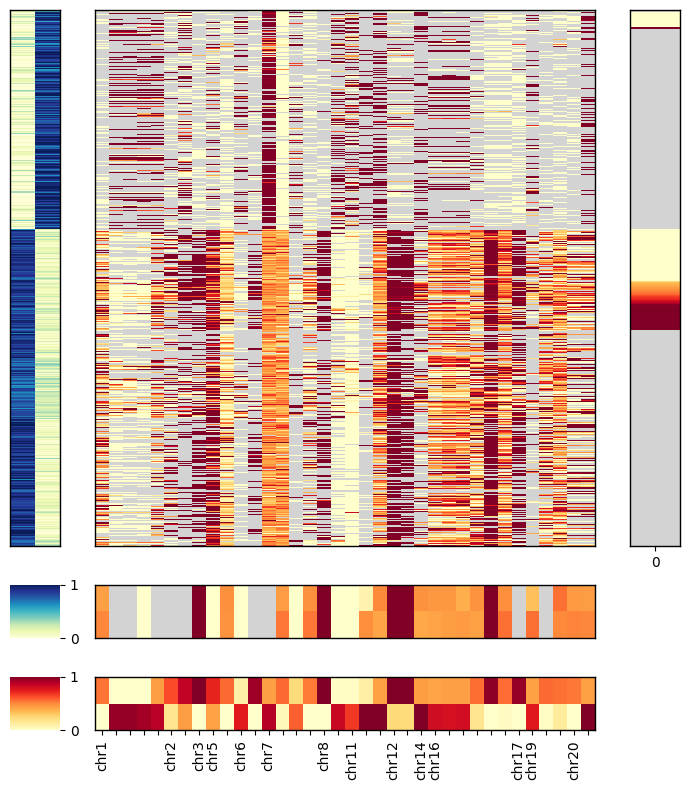

In [34]:
fig,((axs_0), (axs_1), (axs_2)) = plt.subplots(3,3,gridspec_kw={'height_ratios':[1,.1, .1],
                                                                      'width_ratios':[.1,1,.1]}, figsize=(7,8))
args = {"yticklabels":[], "vmin":0, "vmax":1, "cbar_ax":axs_2[0], "cmap":var_cmap}

#################
# plot C matrix # 
#################
g = sns.heatmap(adata.obsm["C"], ax=axs_0[0], 
                cmap=cell_cmap,  xticklabels=[], yticklabels=[], vmin=0, vmax=1, cbar_ax=axs_1[0])
set_border(g)

g = sns.heatmap(np.array([leuk_VAF.loc[row_ind]]).T, ax=axs_0[2], **args)
set_border(g)
axs_1[2].axis('off')
axs_2[2].axis('off')

#################################
# plot vars enriched in clone 0 # 
#################################
# get relevant variants
sub_vars = (np.abs(np.diff(V, axis=1))[:,0])>.3  # only high FC vars
sub_vars &= expressed
# plot VAF
g = sns.heatmap(VAF[:,sub_vars], ax=axs_0[1],  xticklabels=[], **args)
set_border(g)
# plot the variant weights
ylab = make_labels(adata[:,sub_vars])
g = sns.heatmap(V[sub_vars].T, ax=axs_2[1], xticklabels=ylab, **args)
set_border(g)
# plot the VAF in whole exome
g = sns.heatmap(WE_VAF[sub_vars].T, ax=axs_1[1], xticklabels=[], **args)
set_border(g)
    

#################
# show and save # 
#################
plt.tight_layout()
save_path = "../figures/S7_C_P3-variants.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)
plt.show()
plt.close()

In [35]:
expressed &= adata.var.cancer_cov>5
expressed &= adata.var.healthy_cov>5

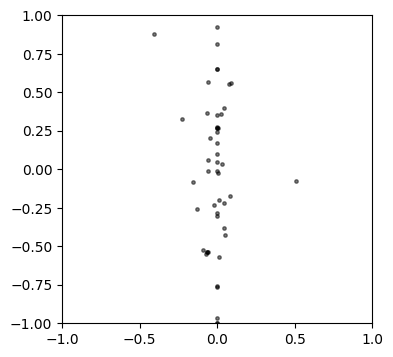

In [37]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

#plt.scatter((WE_VAF[:,0]-WE_VAF[:,1])[~expressed], (V[:,0]-V[:,1])[~expressed], alpha=.5, color="grey", s=6)
plt.scatter((WE_VAF[:,0]-WE_VAF[:,1])[expressed], (V[:,1]-V[:,0])[expressed], alpha=.5, color="black", s=6)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
save_path = "../figures/S10_P3-weights.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)